In [39]:
import rasterio
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [40]:
at_images=glob("/home/prateekjha/ai4boundaries_data/orthophoto/images/AT/*")
at_mask=glob("/home/prateekjha/ai4boundaries_data/orthophoto/masks/AT/*")

In [1]:
print(sorted(at_images))
print(sorted(at_mask))


NameError: name 'at_images' is not defined

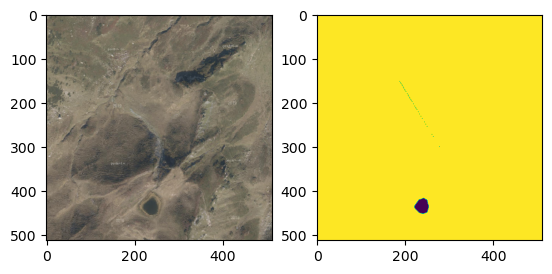

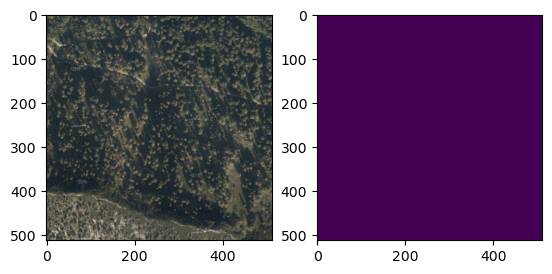

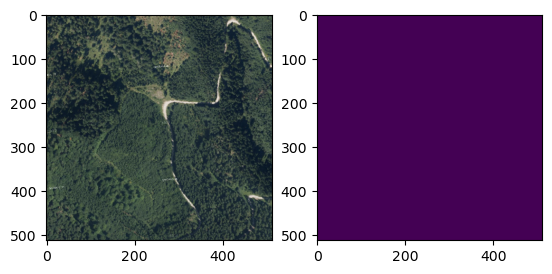

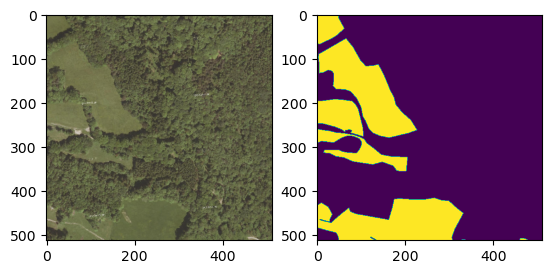

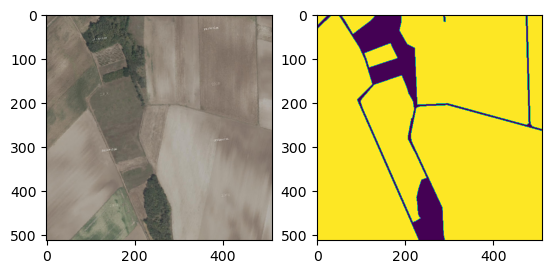

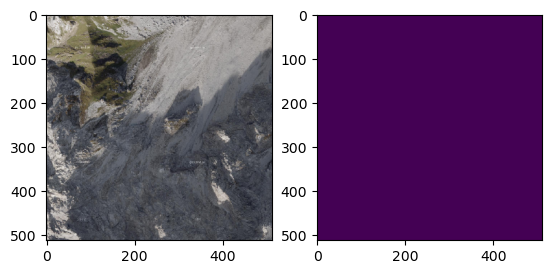

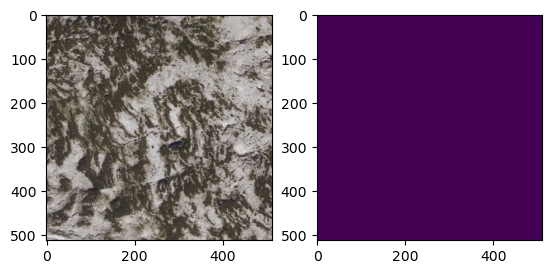

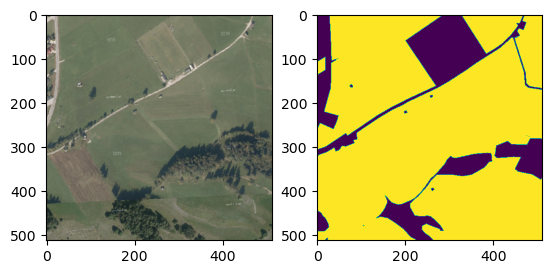

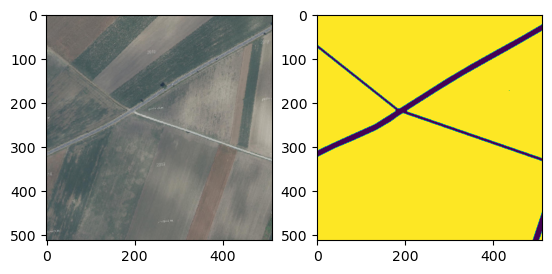

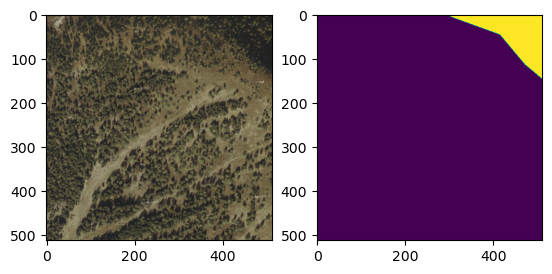

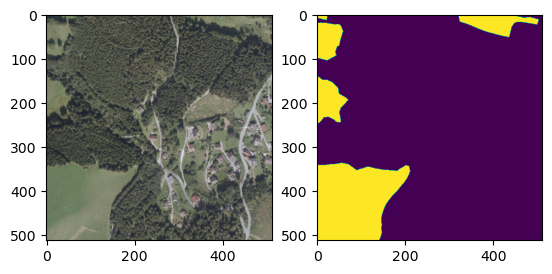

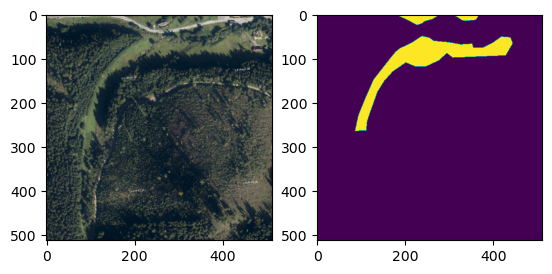

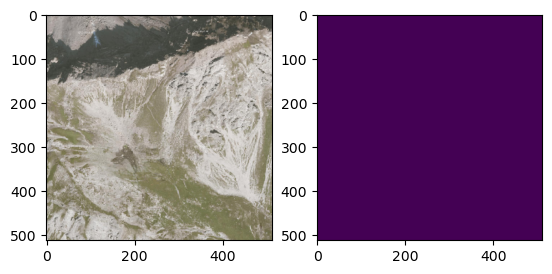

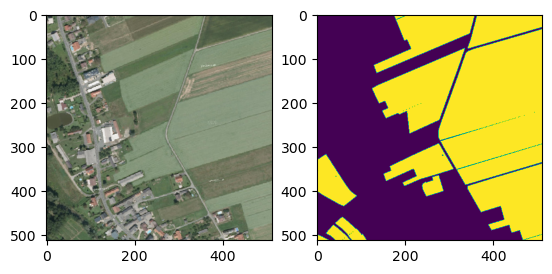

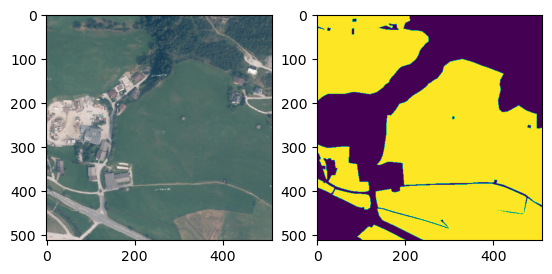

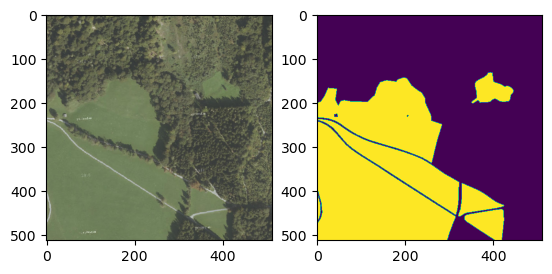

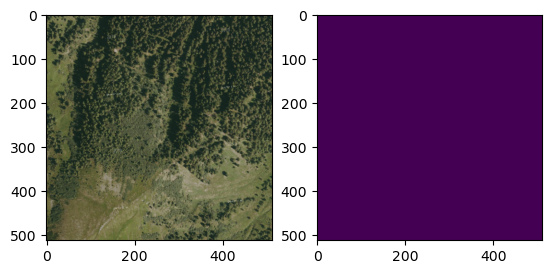

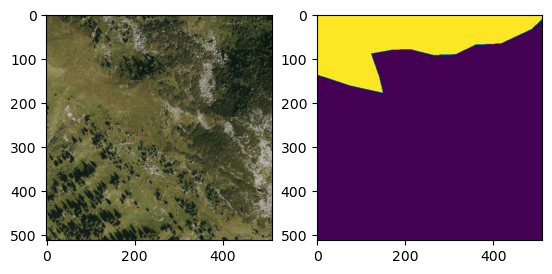

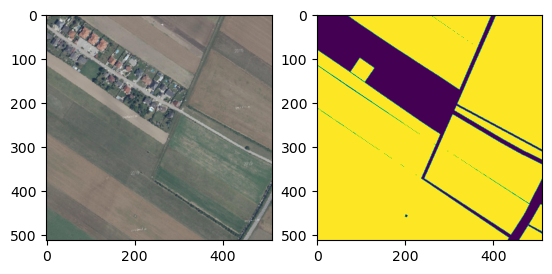

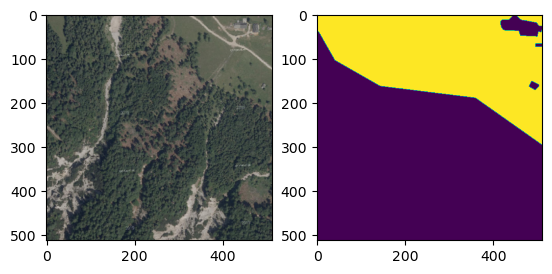

In [ ]:
for at_image_path in at_images[:20]:
    fig,ax=plt.subplots(1,2)
    image_id=at_image_path.split("/")[-1].split("_")[1]
    image=rasterio.open(at_image_path).read().transpose(1,2,0)
    
    mask_path=f"/home/prateekjha/ai4boundaries_data/orthophoto/masks/AT/AT_{image_id}_ortholabel_1m_512.tif"
    mask=rasterio.open(mask_path).read().transpose(1,2,0)
    
    ax[0].imshow(image)
    ax[1].imshow(mask[:,:,0])
    plt.show()

In [4]:
from notebooks.dataset import TrainDataset

In [5]:
train_image = '/home/prateekjha/ai4boundaries_data/orthophoto/images/AT/'
train_label = '/home/prateekjha/ai4boundaries_data/orthophoto/masks/AT/'
train_data = TrainDataset(train_image, train_label,is_robustness=False)

In [7]:
next(iter(train_data))[0].size()

torch.Size([3, 512, 512])

In [2]:
import torch
import torch.nn as nn
class SpatialPriorModule(nn.Module):
    def __init__(self, inplanes=64, embed_dim=384, with_cp=False):
        super().__init__()
        self.with_cp = with_cp

        self.stem = nn.Sequential(*[
            nn.Conv2d(3, inplanes, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LayerNorm(inplanes),
            nn.ReLU(inplace=True),
            nn.Conv2d(inplanes, inplanes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LayerNorm(inplanes),
            nn.ReLU(inplace=True),
            nn.Conv2d(inplanes, inplanes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.LayerNorm(inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ])
        self.conv2 = nn.Sequential(*[
            nn.Conv2d(inplanes, 2 * inplanes, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LayerNorm(2 * inplanes),
            nn.ReLU(inplace=True)
        ])
        self.conv3 = nn.Sequential(*[
            nn.Conv2d(2 * inplanes, 4 * inplanes, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LayerNorm(4 * inplanes),
            nn.ReLU(inplace=True)
        ])
        self.conv4 = nn.Sequential(*[
            nn.Conv2d(4 * inplanes, 4 * inplanes, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LayerNorm(4 * inplanes),
            nn.ReLU(inplace=True)
        ])
        self.fc1 = nn.Conv2d(inplanes, embed_dim, kernel_size=1, stride=1, padding=0, bias=True)
        self.fc2 = nn.Conv2d(2 * inplanes, embed_dim, kernel_size=1, stride=1, padding=0, bias=True)
        self.fc3 = nn.Conv2d(4 * inplanes, embed_dim, kernel_size=1, stride=1, padding=0, bias=True)
        self.fc4 = nn.Conv2d(4 * inplanes, embed_dim, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        
        def _inner_forward(x):
            c1 = self.stem(x)
            c2 = self.conv2(c1)
            c3 = self.conv3(c2)
            c4 = self.conv4(c3)
            c1 = self.fc1(c1)
            print(c1.size())
            c2 = self.fc2(c2)
            print(c2.size())
            c3 = self.fc3(c3)
            print(c3.size())
            c4 = self.fc4(c4)
            print(c4.size())
    
            bs, dim, _, _ = c1.shape
            # c1 = c1.view(bs, dim, -1).transpose(1, 2)  # 4s
            c2 = c2.view(bs, dim, -1).transpose(1, 2)  # 8s
            c3 = c3.view(bs, dim, -1).transpose(1, 2)  # 16s
            c4 = c4.view(bs, dim, -1).transpose(1, 2)  # 32s
    
            return c1, c2, c3, c4
        
        if self.with_cp and x.requires_grad:
            outs = cp.checkpoint(_inner_forward, x)
        else:
            outs = _inner_forward(x)
        return outs

In [3]:
model=SpatialPriorModule()

In [4]:
x=torch.rand((1,3,1024,1024))

In [5]:
model(x)

RuntimeError: Given normalized_shape=[64], expected input with shape [*, 64], but got input of size[1, 64, 512, 512]

In [7]:
len(model(x))

4